# **Feature extraction**

## **This Notebook**
In this notebook we will perfom feature extraction
- HSV
- HOG

### **1.1 Import necessary libaries**

In [10]:
import os
import pandas as pd
import numpy as np
import requests
from PIL import Image, UnidentifiedImageError
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import requests
import scipy.cluster.hierarchy as sch
import openai
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MultiLabelBinarizer
import random
import cv2
from skimage.feature import hog
from skimage import data, exposure

### **1.2 Load the dataset**

In [12]:
df = pd.read_csv('movie_df_clean.csv')

In [14]:
# List of images
images = []


# Iterate over each movie ID in the 'tconst' column of the DataFrame
for id in df['tconst']:
    try: 
        # Construct the image file path based on the movie ID
        image_path = 'Data/WithText/' + id + '.jpg'

        # Open the image file
        image = Image.open(image_path)
        
        # Add to images
        images.append(image)

        # Convert the image into a NumPy array
        image_array = np.array(image)

       
    # Handle the case where the image file is missing
    except FileNotFoundError:
        # Remove the row corresponding to the missing poster from the DataFrame
        df = df[df["tconst"] != id]

    # Handle cases where the image file is corrupted or not a valid image
    except UnidentifiedImageError:
        # Remove the row corresponding to the invalid poster from the DataFrame
        df = df[df["tconst"] != id]

        # Delete the corrupted or unrecognized image file from the directory
        os.remove(image_path)

In [16]:
histograms = []
histograms_summary = []

for i, id in enumerate(df['tconst']):

    image_path = 'Data/WithText/' + id + '.jpg'
    im = Image.open(image_path)
    
    # Convert image to HSV
    image = np.array(im.convert("RGB"))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    im.close()
    
    # Compute HSV histogram
    hist = cv2.calcHist([image], [0, 1, 2], None, (32, 32, 32), [0, 180, 0, 256, 0, 256])
    hist = hist / np.sum(hist)
    
    hue_channel = np.sum(hist, axis=(1, 2))
    saturation_channel = np.sum(hist, axis=(0, 2))
    value_channel = np.sum(hist, axis=(0, 1))
    
    histograms.append(np.concatenate((hue_channel, saturation_channel, value_channel)))
    
    # Compute moments for each channel (H, S, V)
    moments = []
    for i in range(3):  # H, S, V channels
        channel = image[:, :, i]
        moments.append(np.mean(channel))
        moments.append(np.std(channel))
        moments.append(np.mean((channel - np.mean(channel))**3)) 
   
    histograms_summary.append(np.array(moments))
    

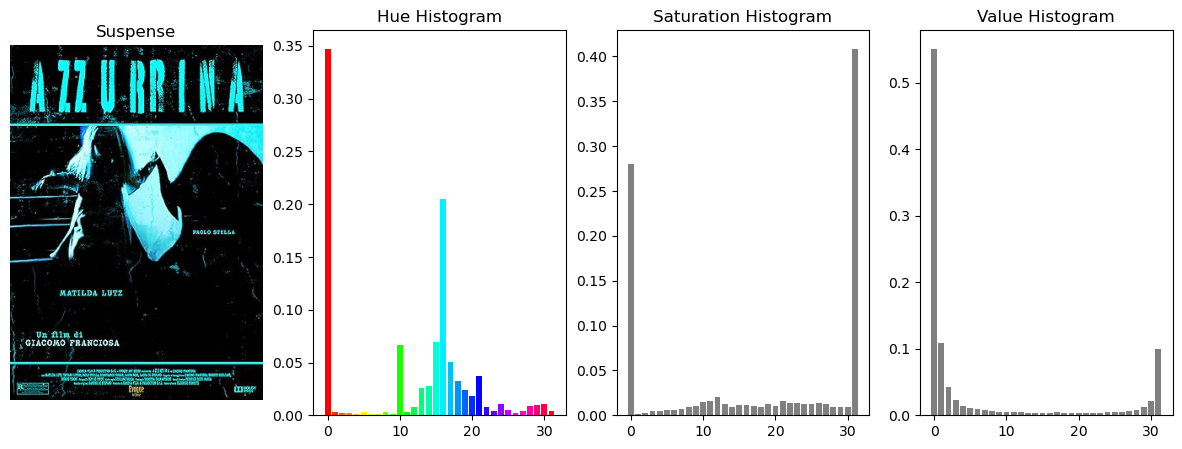

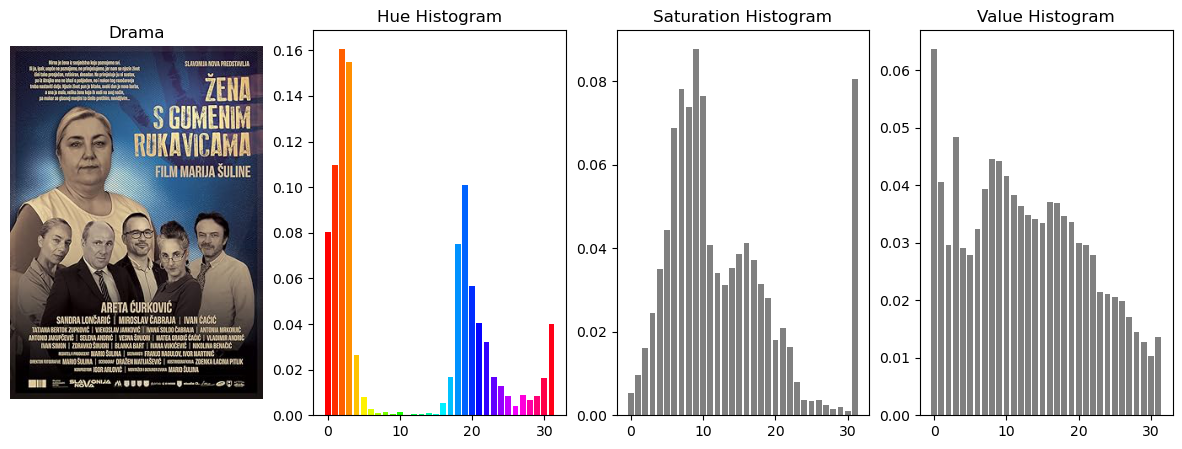

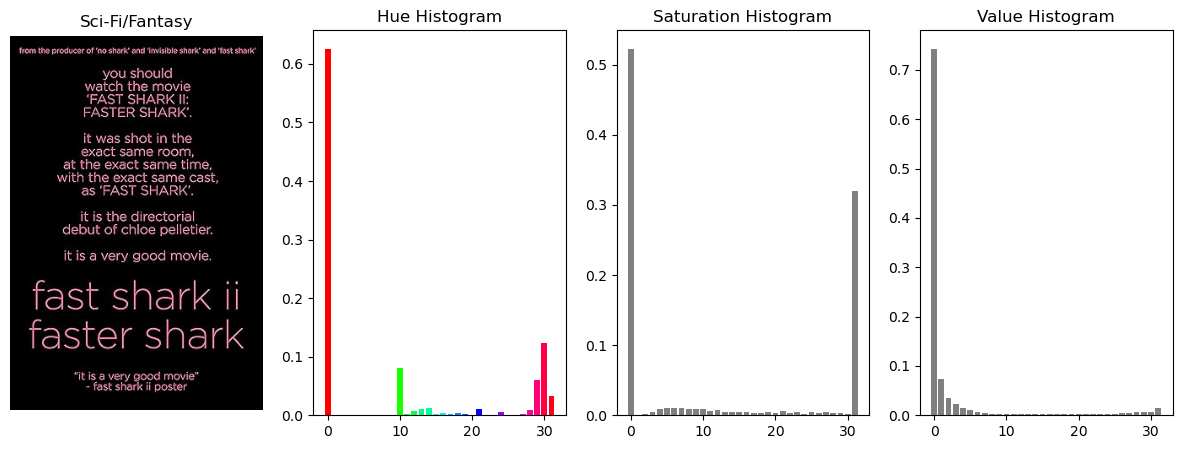

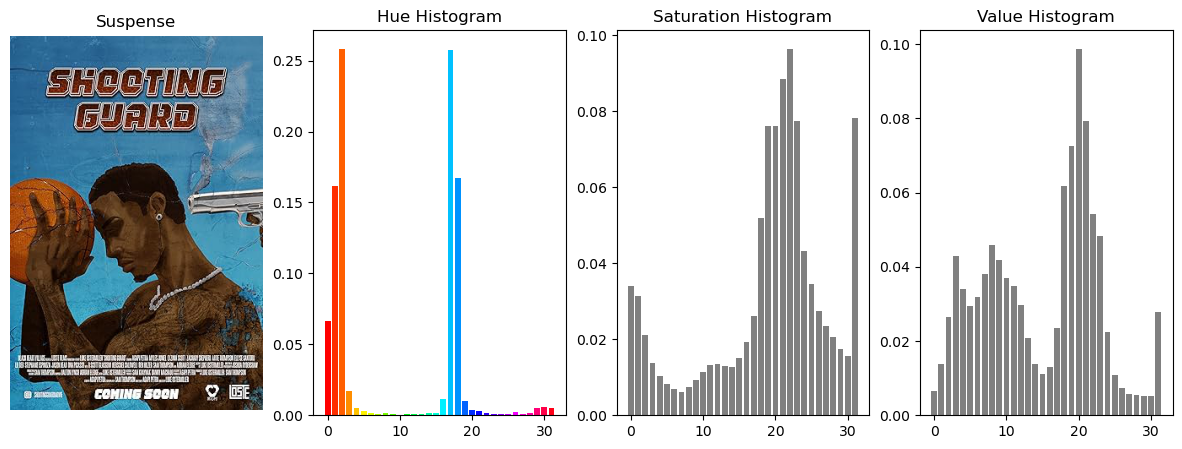

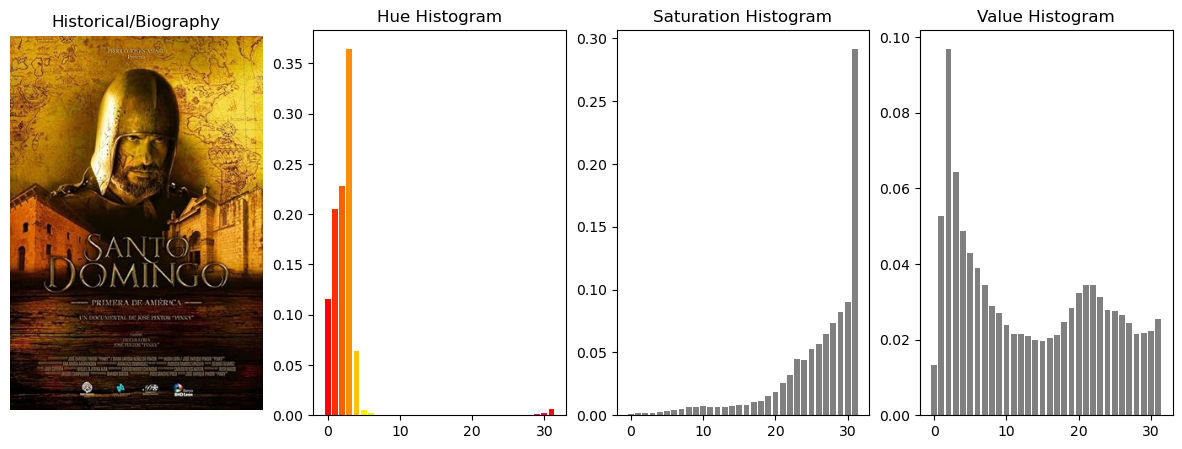

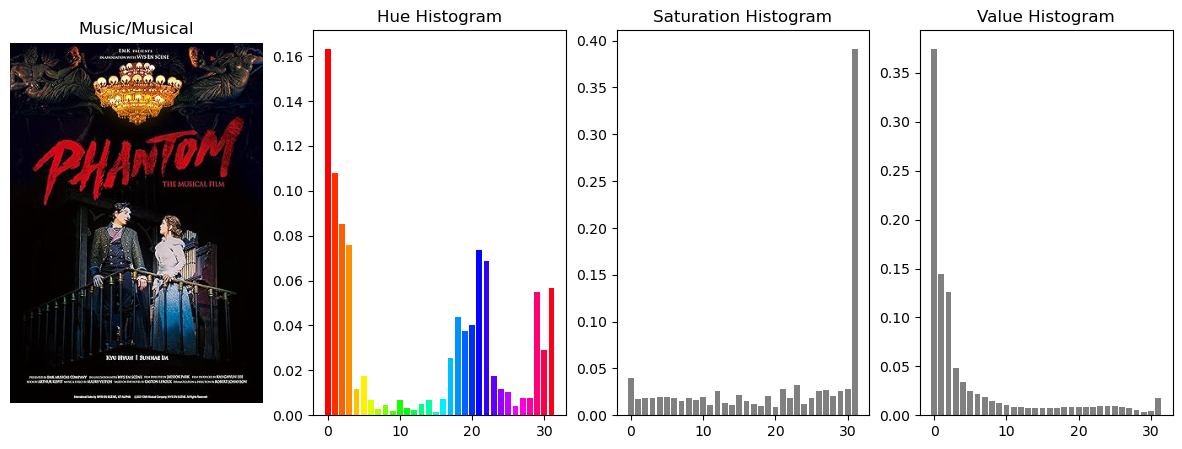

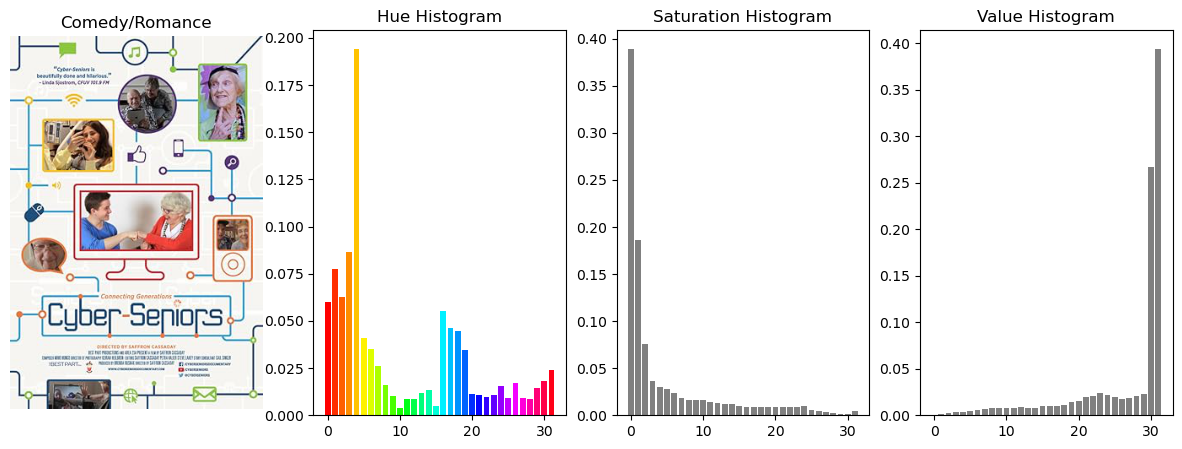

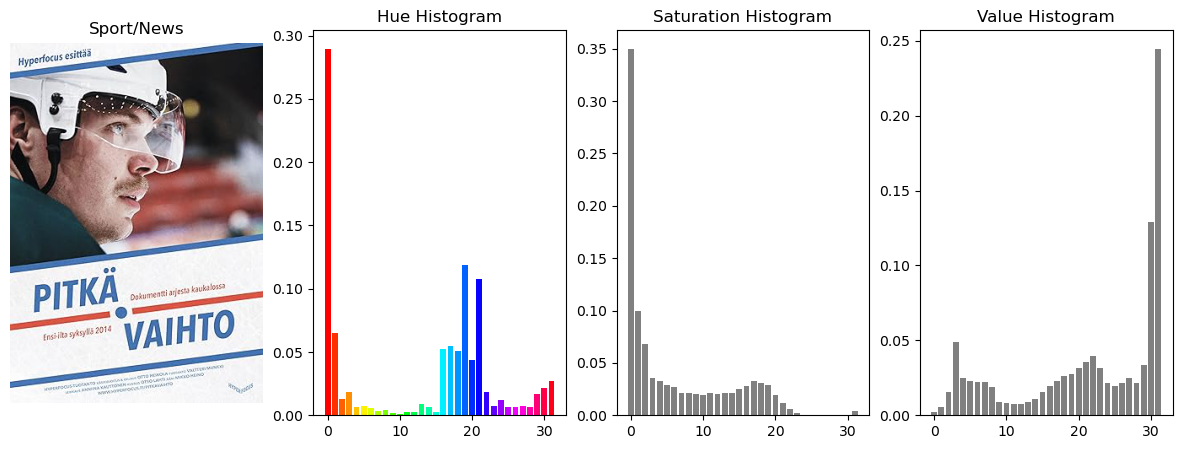

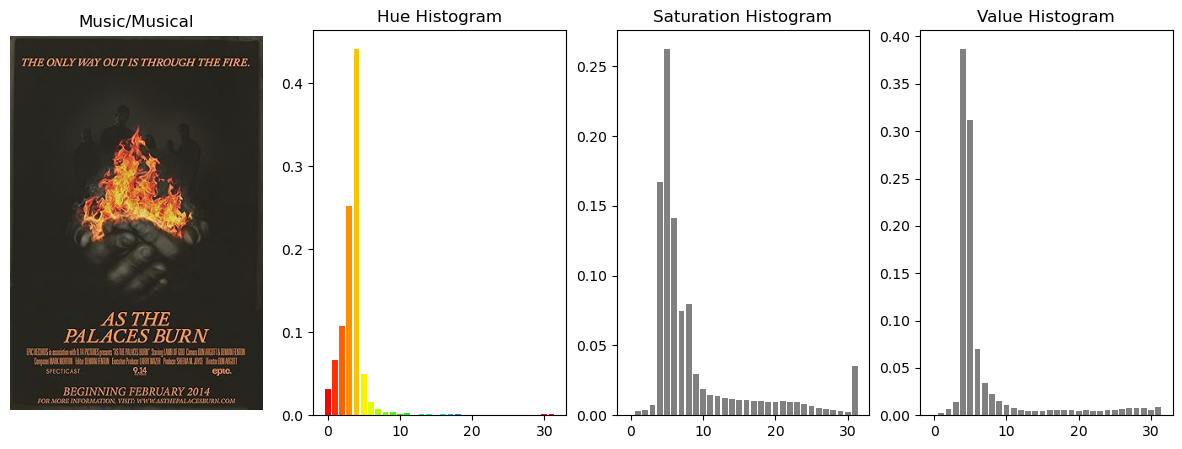

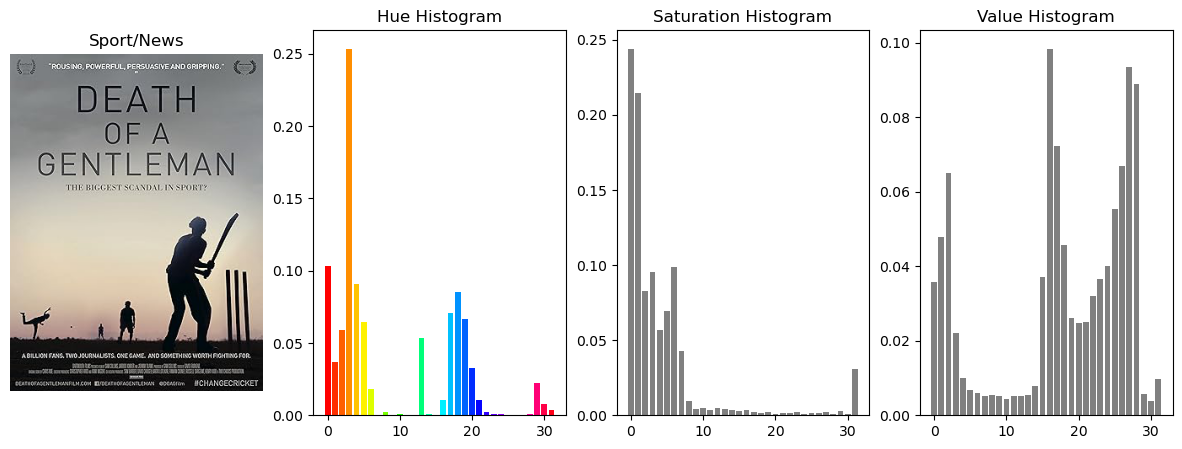

In [5]:
for image_index in range(0,10):
#     image_index = image_index

    image = images[image_index]
    histogram = histograms[image_index]


    # Extract Hue by summing across Saturation and Value
    hue_channel = histogram[0:32]

    # Extract Saturation by summing across Hue and Value
    saturation_channel = histogram[32:64]

    # Extract Value by summing across Hue and Saturation
    value_channel = histogram[64:96]

    hist_channels = [hue_channel, saturation_channel, value_channel]

    fig, axes = plt.subplots(1, 4, figsize=(15, 5))

    bins = len(hue_channel)
    hues = np.linspace(0, 360, bins)

    # Create the color map
    cmap = plt.cm.hsv  # Use the HSV colormap for colors


    axes[0].imshow(image)
    axes[0].axis('off')  # Hide axis for the image
    axes[0].set_title(df.iloc[image_index].reduced_genre)

    for i, (col, ax) in enumerate(zip(['Hue', 'Saturation', 'Value'], axes[1:])):

        if col == "Hue":
            ax.bar(np.arange(bins), hue_channel, color=cmap(hues / 360))
        else:
            ax.bar(np.arange(len(hist_channels[i])), hist_channels[i], color="grey")

        ax.set_title(f'{col} Histogram')

In [6]:
# Create a feature matrix
labels = np.array(df.reduced_genre).reshape(-1, 1)
labels.shape

(29265, 1)

In [7]:
features = np.array(histograms_summary)
features.shape

(29265, 9)

In [8]:
table_hsv = np.concatenate((labels, features), axis = 1)
df_hsv = pd.DataFrame(table_hsv)
df_hsv.columns = [
    'label',
    'mean_hue', 'sd_hue', 'skewness_hue', 
    'mean_saturation', 'sd_saturation', 'skewness_saturation', 
    'mean_value', 'sd_value', 'skewness_value'
]

df_hsv.head()

label   mean_hue     sd_hue   skewness_hue mean_saturation  \
0              Suspense  61.926952  50.229168   -4138.772105      148.128812   
1                 Drama  63.771647   57.61441   82380.400678      104.819753   
2        Sci-Fi/Fantasy  49.847432   70.99652  331975.426297       98.716486   
3              Suspense  56.011344  47.478837   25373.597817      156.208776   
4  Historical/Biography  16.371502  18.351998   43581.143695      212.346374   

  sd_saturation skewness_saturation  mean_value   sd_value  skewness_value  
0     109.30974      -443135.492288   53.432359  89.741972  1093140.460557  
1     62.223364       246509.476436  105.510859  67.725055    82107.055713  
2    116.402144        759435.50236   21.169955  56.039345   553649.843232  
3     66.298206      -245599.841212  123.064805  62.225475   -21519.730837  
4     49.294964       -197149.40415  109.887935  77.142235   127950.425466

In [9]:
# check min and max values
max_value_row = df_hsv.loc[df_hsv['mean_value'].idxmax()]
max_value_row

label                      Suspense
mean_hue                        0.0
sd_hue                          0.0
skewness_hue                    0.0
mean_saturation                 0.0
sd_saturation                   0.0
skewness_saturation             0.0
mean_value                253.25645
sd_value                  16.822923
skewness_value        -54702.573245
Name: 2233, dtype: object

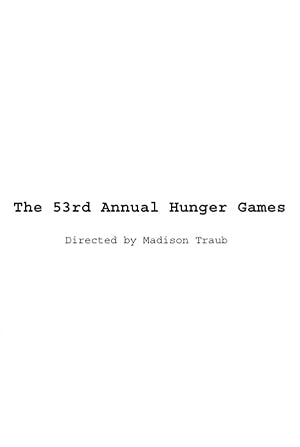

In [10]:
images[2233]

In [11]:
min_value_row = df_hsv.loc[df_hsv['mean_value'].idxmin()]
min_value_row

label                       Suspense
mean_hue                    2.020404
sd_hue                      7.820693
skewness_hue             2444.931168
mean_saturation             8.621206
sd_saturation              40.001099
skewness_saturation    330144.108253
mean_value                  1.805858
sd_value                   15.082665
skewness_value          43927.529233
Name: 21242, dtype: object

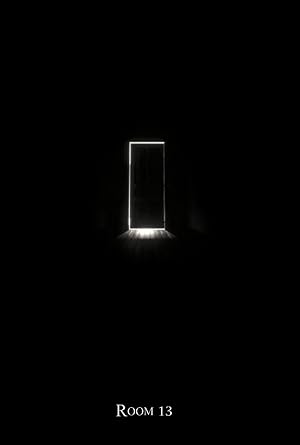

In [12]:
images[21242]

In [13]:
mean_values = df_hsv.groupby('label')[['mean_hue', 'mean_saturation', 'mean_value']].mean()
mean_values

mean_hue mean_saturation  mean_value
label                                                      
Action/Adventure      59.568793      104.124157  135.017089
Comedy/Romance         55.29035       96.991057  149.053077
Drama                  53.19953       92.038001  132.666465
Historical/Biography  50.475364       86.019575  131.594047
Music/Musical         57.040297       97.241226  125.414357
Sci-Fi/Fantasy        62.314655      102.655017  114.915367
Sport/News            55.920888       92.430512  136.863779
Suspense               55.21468      101.176412  100.002413
War/Crime             51.880404       92.551339  115.878962
Western/Family        53.397091       99.359396  149.448787

/var/folders/4m/yp2tjgp53mqd_cn82ymt0ffh0000gn/T/ipykernel_57957/2072101493.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df_hsv.groupby("label").apply(lambda x: x.sample(200, random_state=42)).reset_index(drop=True)


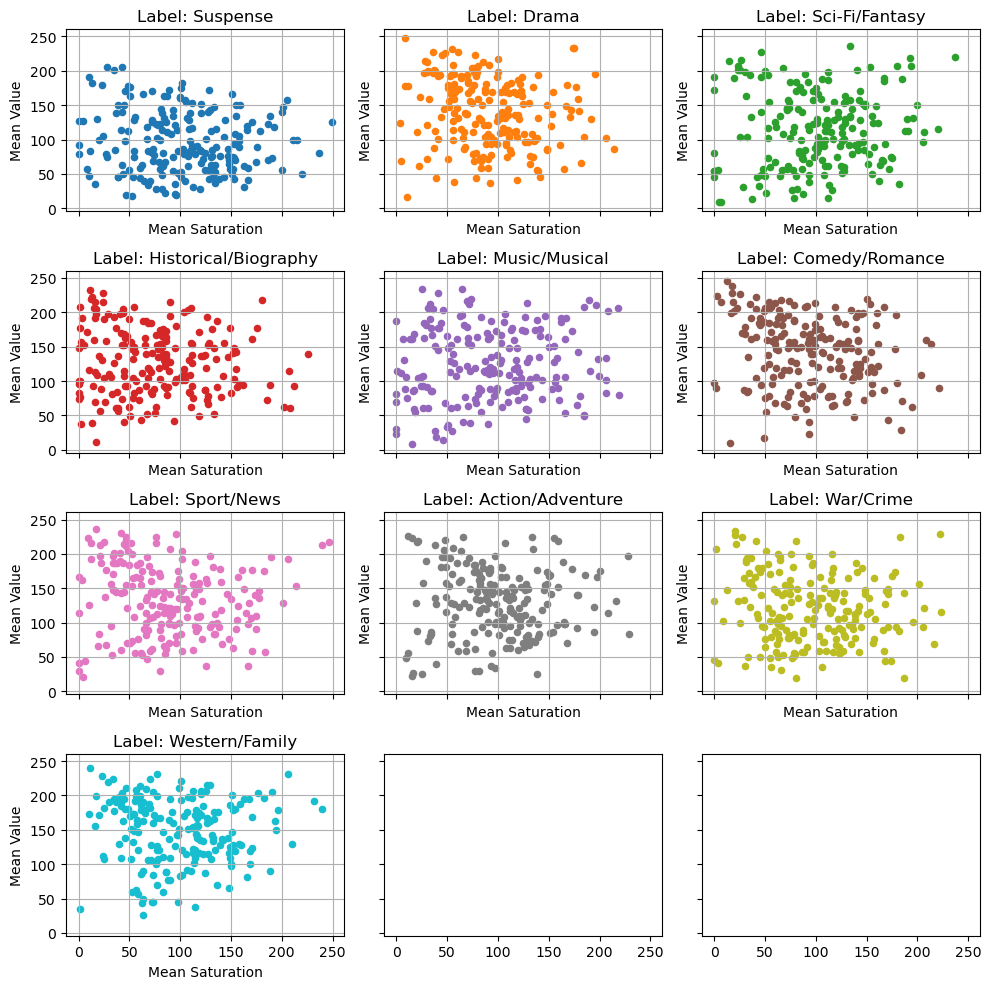

In [32]:
# Plot

# Sample 100 points from each label
sampled_df = df_hsv.groupby("label").apply(lambda x: x.sample(200, random_state=42)).reset_index(drop=True)

labels = df_hsv.label.unique()




fig, axes = plt.subplots(4, 3, figsize=(10, 10), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten to make indexing easier

# Unique colors for each label using seaborn color palette
colors = sns.color_palette("tab10", len(labels))

# Plot each label in its own subplot
for i, label in enumerate(labels):
    ax = axes[i]
    
    # Filter DataFrame for current label
    label_df = sampled_df[sampled_df["label"] == label]
    
    # Scatter plot for the label
    ax.scatter(label_df["mean_saturation"], label_df["mean_value"], color=colors[i], s=20, label=f"Label: {label}")
    
    # Titles and labels
    ax.set_title(f"Label: {label}", fontsize=12)
    ax.set_xlabel("Mean Saturation")
    ax.set_ylabel("Mean Value")
    ax.grid(True)
    
# Adjust layout
plt.tight_layout()
plt.show()

In [33]:
# hog features

# We assume that different genres have distinct visual styles. Histogram of gradient can 
# captures these by capturing for example:
# - Edges: action movies might have sharper edges and more pronounced contrasts compared to drama posters which might have softer gradients and smoother transitions
# - Text Style: fonts and layouts might even be a cue rather than a distraction

In [36]:
hog_features = []
hog_images = []

for i in range(0, 1000):
    
#     im_gray = cv2.cvtColor(np.array(images[i]), cv2.COLOR_BGR2GRAY) / 255.0
    
    im_gray = np.array(images[i].convert("L")) / 255.0
    
    height, width = im_gray.shape
    
    # We to clear more images with a min width and hight 
    crop_width = 300
    crop_height = 400
    start_x = (width - crop_width) // 2
    start_y = (height - crop_height) // 2
    
    im_cropped = im_gray[start_y:start_y + crop_height, start_x:start_x + crop_width]
    

    fd, hog_image = hog(im_cropped, orientations=8, pixels_per_cell=(16, 16),
                        cells_per_block=(1, 1), visualize=True)
    

    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 1))
    
    hog_features.append(fd)
    hog_images.append(hog_image_rescaled)

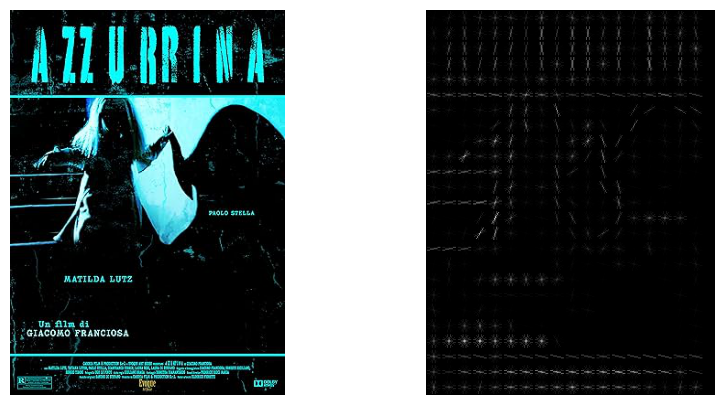

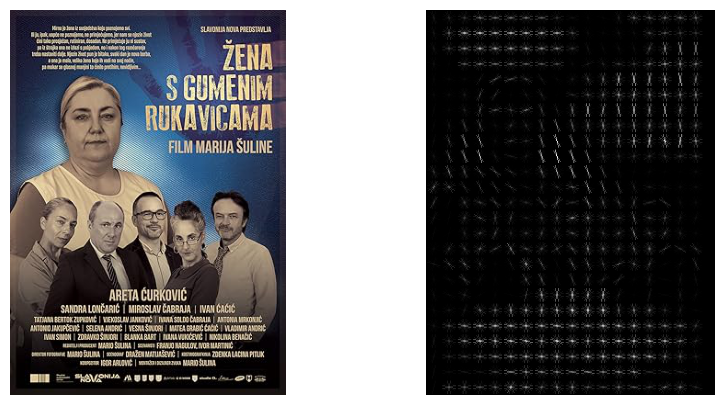

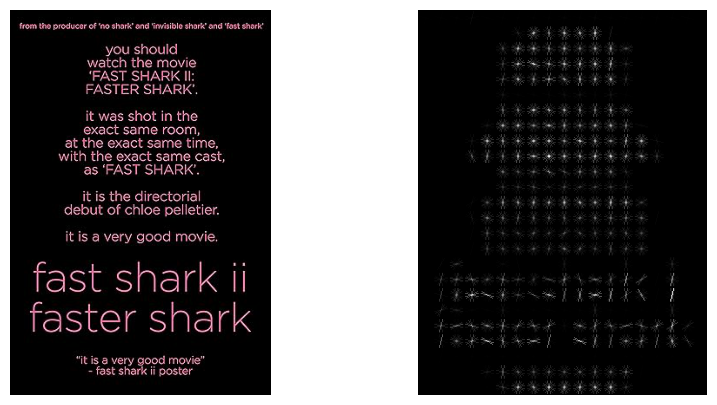

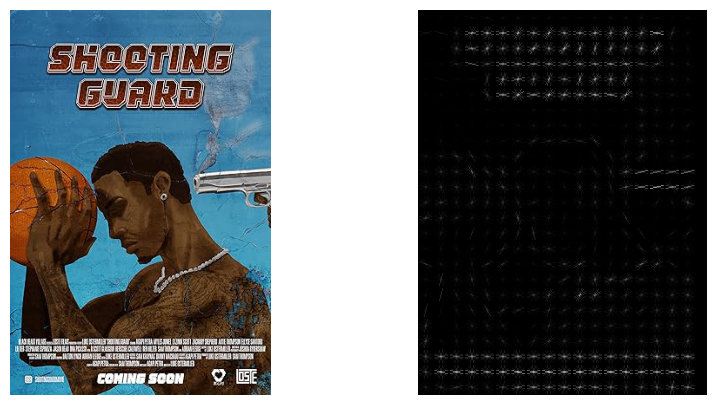

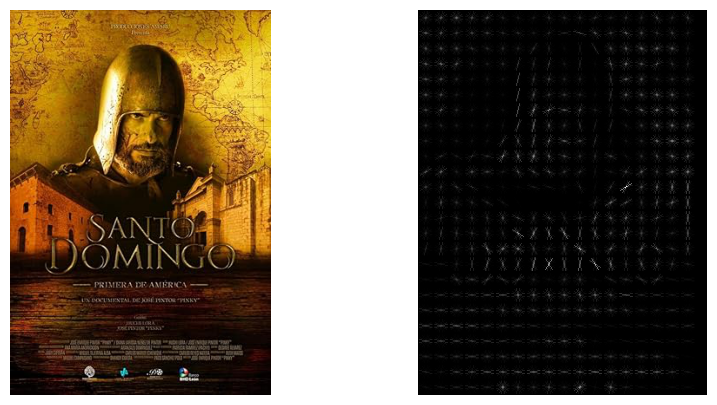

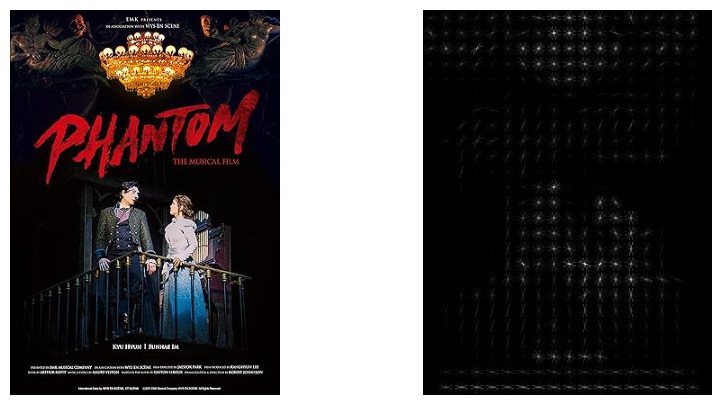

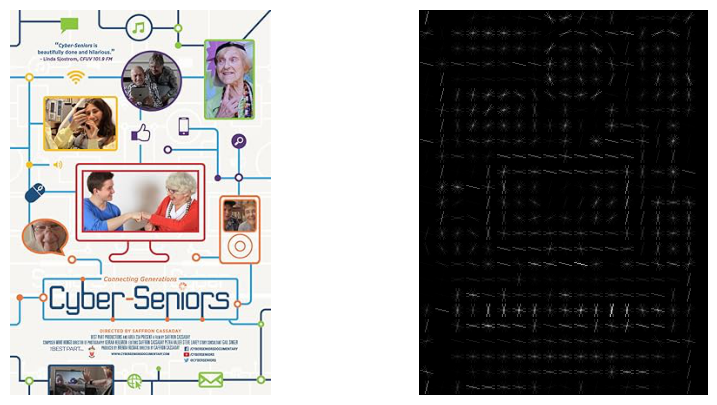

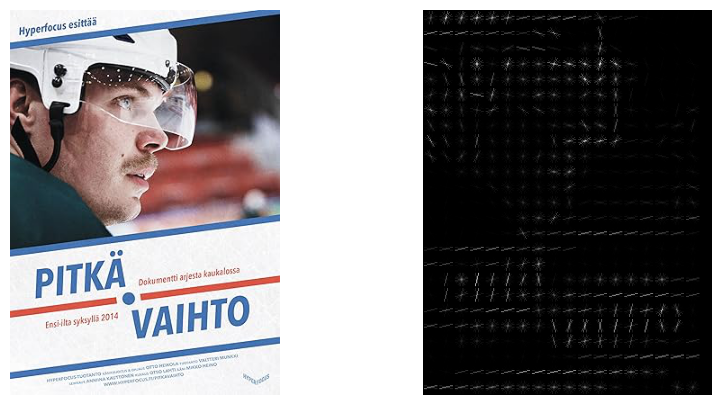

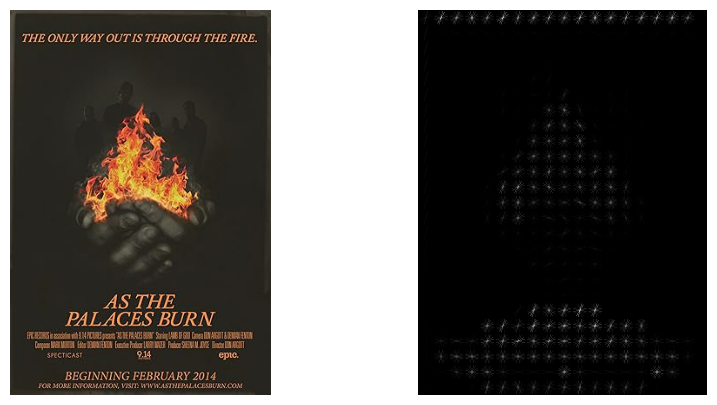

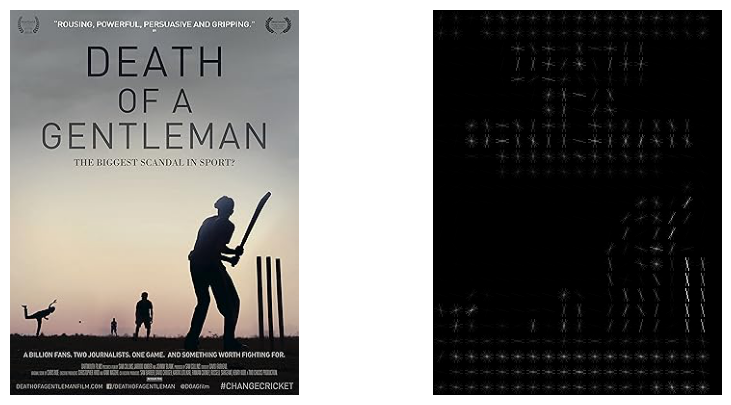

In [43]:
for i in range(0,10):
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.imshow(images[i], cmap='gray')
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(hog_images[i], cmap='gray')
    plt.axis('off')
    plt.show()

In [38]:
for i in range(1000):
    print(f"Original Image Shape: {np.array(images[i]).shape}")
    print(f"Hog feature shape: {hog_features[i].shape}")
    print("--"*20)

Original Image Shape: (421, 300, 3)
Hog feature shape: (3600,)
----------------------------------------
Original Image Shape: (419, 300, 3)
Hog feature shape: (3600,)
----------------------------------------
Original Image Shape: (444, 300, 3)
Hog feature shape: (3600,)
----------------------------------------
Original Image Shape: (444, 300, 3)
Hog feature shape: (3600,)
----------------------------------------
Original Image Shape: (444, 300, 3)
Hog feature shape: (3600,)
----------------------------------------
Original Image Shape: (428, 300, 3)
Hog feature shape: (3600,)
----------------------------------------
Original Image Shape: (443, 300, 3)
Hog feature shape: (3600,)
----------------------------------------
Original Image Shape: (428, 300, 3)
Hog feature shape: (3600,)
----------------------------------------
Original Image Shape: (444, 300, 3)
Hog feature shape: (3600,)
----------------------------------------
Original Image Shape: (400, 300, 3)
Hog feature shape: (3600,)
-

In [39]:
features = np.array(hog_features)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (1000,) + inhomogeneous part.

In [ ]:
features.shape